In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import scipy
import pickle as pkl

from haplm.hap_util import mat_by_marker
from sim_data import parse_sim_data

# Simulation study of Section 3.2

This part is to compare the statistical and computational performance of the methods when applied to pooled multinomial data that share the same multinomial probabilities. 3 markers (8 haplotypes) are used, and the observed counts are the allele counts of each marker for each pool. 

Five sets of multinomial probabilities have been simulated from the distribution $\mathbf{p}\sim \mathrm{Dir}(0.4,\ldots,0.4)$. For each of these sets, five datasets of $N=20$ pools each are simulated, where the pool sizes (number of haplotype samples per pool) are $20,40,60,80,100$.

Accuracy of a point estimate of $\mathbf{p}$ is measured by total variation distance (TVD), defined as half the sum of absolute errors. Efficiency is measured by the minimum effective sample size of $\mathbf{p}$. 

The methods developed are:
- Exact marginalisation. This method solves the discrete linear system in order to sum up the probability mass function across all compatible latent counts. Does not scale well with pool size, but is considered as the gold standard for accuracy.
- Markov basis sampling. This method uses collapsed Gibbs sampling to sample $p(\mathbf{z}_i\vert\mathbf{Z}_{-i})$. This method exploits conjugacy by assuming a Dirichlet prior for $\mathbf{p}$. 
- Normal approximation. This methods approximately marginalises out the latent counts. 

The existing methods used for comparison are HIPPO and AEML.

In [2]:
n_datasets = 5
n_pools = 20
n_markers = 3
H = 2**n_markers # number of input haplotypes
pool_sizes = np.arange(20, 101, 20)
amat = mat_by_marker(n_markers)
alphas = np.ones(H)

In [3]:
from matplotlib import rc, rcParams
# comment out if no tex
rc('font', **{'family': 'serif', 'serif': ['Palatino']})
rc('text', usetex = True)
rc('font', size=14)

# colors for plotting
colors = [
    '#1b9e77',
    '#d95f02',
    '#7570b3',
    '#e7298a',
    '#66a61e',
    '#e6ab02'
]

In [4]:
def get_pmean(idata):
    return idata.posterior.p.values.mean(axis=(0,1))

def get_pess(idata):
    return az.ess(idata, var_names=['p'])['p'].values

def get_walltime(smpl_stat_dict):    
    return smpl_stat_dict.get('preprocess_time', 0) + smpl_stat_dict['mcmc_walltime']

def get_tvd(p1, p2):
    return 0.5*abs(p1-p2).sum()

In [5]:
# read in multinomial probabilities used for simulation
ptrue_list = []
for ds_idx in range(1, n_datasets+1):
    fn_prefix = f'../../data/sim-study/psize{pool_sizes[0]}_m{n_markers}_id{ds_idx}'
    with open(fn_prefix+'.prob') as fp:
        ptrue_list.append(np.array([float(line.strip()) for line in fp]))

In [6]:
# init stats_by_psize
stats_by_psize = {pool_size: [{} for _ in range(n_datasets)] for pool_size in pool_sizes}

In [7]:
# get stats from MCMC results
for method in ['exact', 'cgibbs', 'mn_approx', 'hippo']:
    print(method, end=' ')
    for pool_size in pool_sizes:
        for i in range(n_datasets):
            print(i+1, end=' ')
            stats_dict = stats_by_psize[pool_size][i]
            fn_prefix = f'../../data/sim-study/psize{pool_size}_m{n_markers}_id{i+1}'
            
            idata = az.from_netcdf(f'{fn_prefix}_{method}.netcdf')
            
            pmean = get_pmean(idata)
            quants = (np.vstack(idata.posterior.p) < ptrue_list[i]).mean(axis=0)
            stats_dict[method] = {'pmean': pmean, # posterior mean
                                  'pstd': np.std(idata.posterior.p.values, axis=(0,1)), # posterior SD
                                  'qs': quants, # posterior quantile of 
                                  'pess': get_pess(idata), # ESS of p
                                  'timings': idata.attrs,
                                 }
    print()

exact 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 
cgibbs 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 
mn_approx 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 
hippo 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 


In [8]:
# get stats from AEML
for pool_size in pool_sizes:
    for i in range(n_datasets):
        fn = f'../../data/sim-study/psize{pool_size}_m{n_markers}_id{i+1}_aeml.pkl'           
        with open(fn, 'rb') as fp:
            stats_by_psize[pool_size][i]['AEML'] = pkl.load(fp)

In [9]:
# max runtime of AEML
max(stats_by_psize[pool_size][i]['AEML']['time'] for pool_size in pool_sizes for i in range(n_datasets))

0.2996060848236084

The author of HIPPO suggests to use the chain with the highest average log posterior. We check that this does not improve the total variation distance (TVD) of the posterior mean from the true frequencies.

In [10]:
# get stats from 'best' chain of hippo
for pool_size in pool_sizes:
    for i in range(n_datasets):
        idata = az.from_netcdf(f'../../data/sim-study/psize{pool_size}_m{n_markers}_id{i+1}_hippo.netcdf')          
        c = idata.sample_stats.avg_logpost.values.argmax()
        stats_by_psize[pool_size][i]['hippo_best'] = {'pmean': idata.posterior.p.values[c].mean(axis=0), # posterior mean
                                                      'pstd': np.std(idata.posterior.p.values[c], axis=0), # posterior SD
                                                      'pess': az.ess(idata.sel(chain=[c]), var_names=['p'])['p'].values, # ESS of p
                                                      }

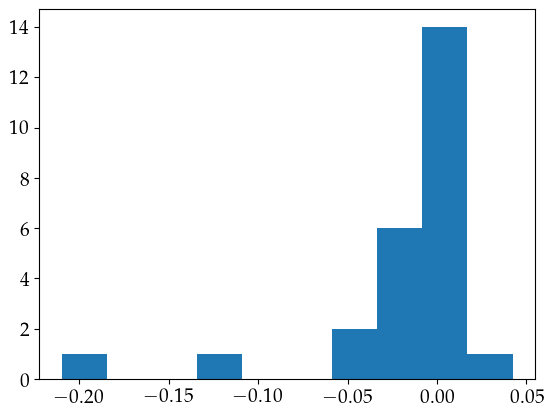

In [11]:
# TVD for HIPPO all chains - TVD for HIPPO best chain
diffs = []
for psize in pool_sizes:
    for i in range(n_datasets):
        all_chains_tvd = get_tvd(stats_by_psize[psize][i]['hippo']['pmean'], ptrue_list[i])
        best_chain_tvd = get_tvd(stats_by_psize[psize][i]['hippo_best']['pmean'], ptrue_list[i])
        diffs.append(all_chains_tvd - best_chain_tvd)
plt.hist(diffs);

# Plot errors and TVD

In [12]:
def plot_errors(ax, method, est_name, title):
    """Plot differences between frequency estimate and true frequencies."""
    pred = []
    trg = []
    scat_sizes = []

    for psize in pool_sizes:
        for idx in range(n_datasets):    
            ptrue = ptrue_list[idx]
            for h,p in enumerate(ptrue):
                pred.append(p)
                trg.append(stats_by_psize[psize][idx][method][est_name][h] - p)
                scat_sizes.append(psize * 0.3)

    ax.scatter(pred,trg,s=scat_sizes,alpha=0.5)
    xlim = ax.get_xlim()
    ax.plot([-1,2],[0,0],'--',color='k',alpha=0.5)
    ax.set_xlim(xlim)
    ax.set_title(title, fontsize=15);

In [13]:
methods = ['exact', 'mn_approx', 'cgibbs', 'AEML', 'hippo']
tvd_dict = {}
for method in methods:
    est_name = 'pest' if method == 'AEML' else 'pmean'
    tvds = []
    for psize in pool_sizes:
        for idx in range(n_datasets):    
            ptrue = ptrue_list[idx]
            tvds.append(get_tvd(stats_by_psize[psize][idx][method][est_name], ptrue))
    tvd_dict[method] = np.array(tvds)

In [14]:
name_dict = {'AEML': 'AEML',
             'hippo': 'HIPPO',
             'cgibbs': 'LC-Sampling',
             'exact': 'MCMC-Exact',
             'mn_approx': 'MCMC-Approx'}

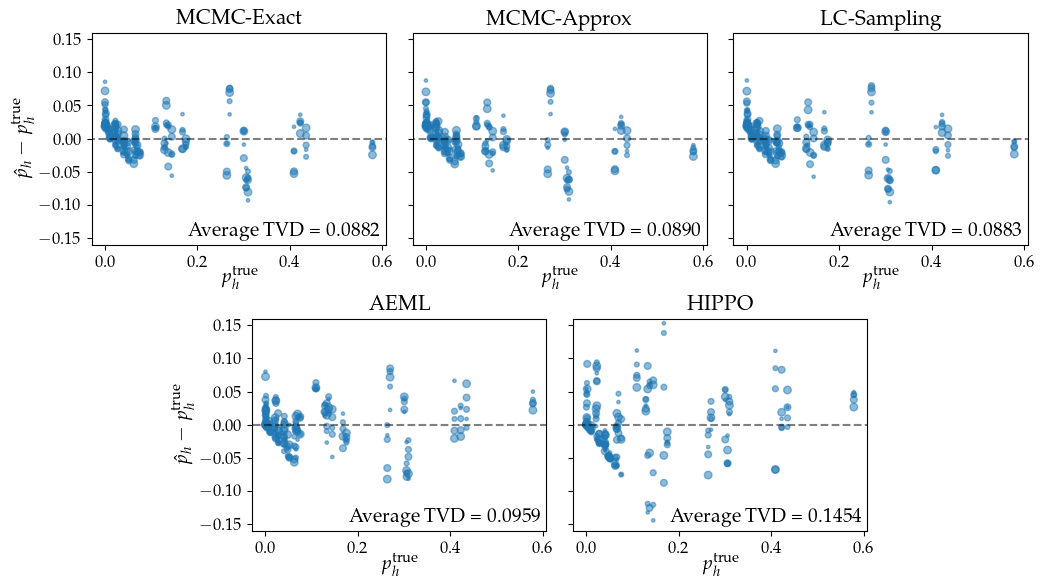

In [15]:
methods = ['exact', 'mn_approx', 'cgibbs', 'AEML', 'hippo']
fig = plt.figure(figsize=(12, 6))
spec = fig.add_gridspec(2, 6)
subplots = (spec[0,:2], spec[0,2:4], spec[0,4:], spec[1,1:3], spec[1,3:5])

for i in range(5):
    ax = fig.add_subplot(subplots[i])
    est_name = 'pest' if methods[i] == 'AEML' else 'pmean'
    plot_errors(ax, methods[i], est_name, name_dict[methods[i]])
    ax.set_ylim((-0.16, 0.16))
    
    tvd_mean = np.mean(tvd_dict[methods[i]])
    ax.text(0.18, -0.146, f'Average TVD = {tvd_mean:.4f}', fontsize=14)
    #ax.plot([0,0.05],[0.02,-0.03], color='k')
    
    yticks = np.arange(-0.15, 0.16, 0.05)
    # xticks = np.arange(0, 0.62, 0.2)
    if i%3:
        ax.set_yticks(yticks, [])
    else:
        ax.set_yticks(yticks)
        ax.set_ylabel(r'$\hat{p}_{h} - p^\mathrm{true}_h$', fontsize=14)
    ax.set_xlabel(r'$p^\mathrm{true}_h$', fontsize=14, labelpad=-4.0)
    ax.tick_params(axis='both', which='both', labelsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.35, top=0.92, left=0.14, right=0.92, bottom=0.09);
plt.savefig('sim_errors.png', dpi=200, facecolor='white');

## ESS and wall times

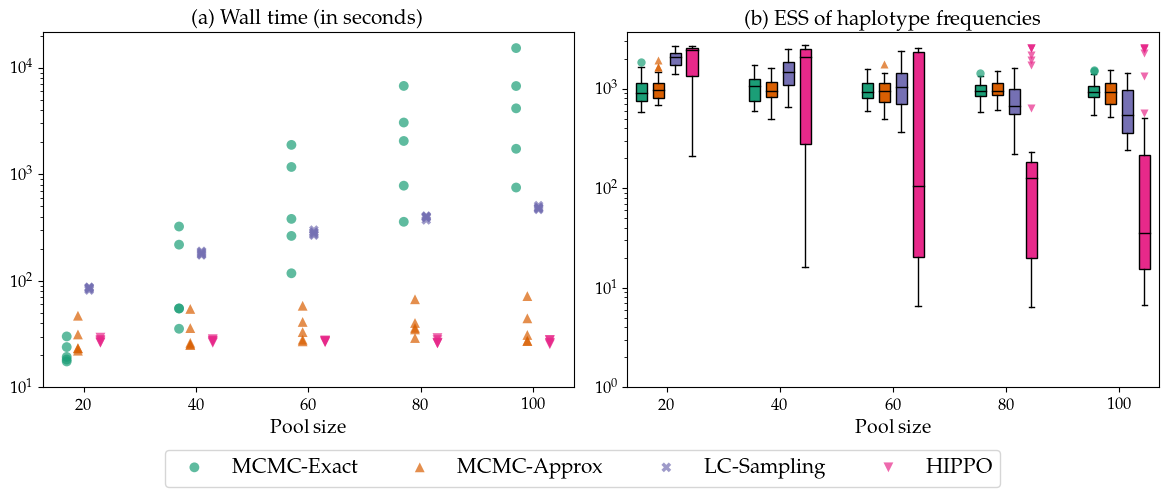

In [16]:
labels = ['MCMC-Exact',
          'MCMC-Approx',
          'LC-Sampling',          
          'HIPPO']
methods = ['exact', 'mn_approx', 'cgibbs', 'hippo']

fig, axes = plt.subplots(figsize=(12,5), ncols=2)

ax = axes[1]
for i, method in enumerate(methods):
    ax.boxplot([[val for stat_dict in stats_by_psize[psize] for val in stat_dict[method]['pess']] for psize in pool_sizes],
               positions=(pool_sizes+(3*i-4.5)), widths=2,
               patch_artist=True, boxprops=dict(facecolor=colors[i]),
               flierprops=dict(alpha=0.7, markerfacecolor=colors[i], markeredgecolor='none', 
                               markersize=6, marker='o^Xv'[i]),
               medianprops=dict(color='k'))

ax.set_xlim((13, 107))
ax.set_xticks(pool_sizes, pool_sizes)
ax.set_xlabel('Pool size', fontsize=14)
ax.set_title('(b) ESS of haplotype frequencies', fontsize=15)
ax.set_yscale('log');
ax.set_ylim((1, ax.get_ylim()[1]))
ax.tick_params(axis='both', which='both', labelsize=12)

ax = axes[0]
for i, method in enumerate(methods):
    ax.scatter(np.repeat(pool_sizes+(2*i-3), n_datasets),
               [get_walltime(stat_dict[method]['timings'])
                for psize in pool_sizes for stat_dict in stats_by_psize[psize]],
               color=colors[i], alpha=0.7, s=50, marker='o^Xv'[i], edgecolor='none', label=labels[i]);
ax.set_xlabel('Pool size', fontsize=14);
ax.set_title('(a) Wall time (in seconds)', fontsize=15);
ax.set_yscale('log');
ax.set_ylim((10, ax.get_ylim()[1]));
ax.tick_params(axis='both', which='both', labelsize=12)

#plt.legend();
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.01), fontsize=15)
plt.subplots_adjust(wspace=0.1, top=0.94, left=0.05, right=0.98, bottom=0.23);
plt.savefig('sim_perf.png', dpi=200, facecolor='white');

## Credible interval coverage

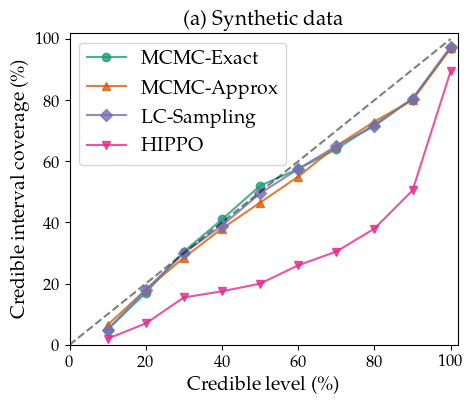

In [17]:
markers = 'o^Dv'

plt.figure(figsize=(6*0.8, 5*0.8))
for j, method in enumerate(['exact', 'mn_approx', 'cgibbs', 'hippo']):
    # print(method)
    quants = []
    for psize in pool_sizes:
        for i in range(n_datasets):
            quants += list(stats_by_psize[psize][i][method]['qs'])
            # for h in range(1, 9):
            #     if quants[-h] == 0 or quants[-h] == 1:
            #         print(quants[-h], ptrue_list[i][-h])
    quants = np.array(quants)
    alphas = np.arange(1, 11) / 10
    coverage = []
    for alpha in alphas:
        coverage.append((abs(quants - 0.5) < alpha/2).mean())
    plt.plot(alphas*100, 100*np.array(coverage), f'{markers[j]}-', alpha=0.8, color=colors[j],
             label=name_dict[method], markersize=6)
plt.plot([0,100], [0,100], '--', alpha=0.5, color='k')

plt.xlim((0,102))
plt.ylim((0,102))

plt.xlabel('Credible level (\%)', fontsize=14)
plt.ylabel('Credible interval coverage (\%)', fontsize=14)
plt.legend(fontsize=14);
plt.title('(a) Synthetic data', fontsize=15);
plt.tick_params(axis='both', which='both', labelsize=12)

plt.subplots_adjust(top=0.92, left=0.15, right=0.96, bottom=0.14);
plt.savefig('synthetic_coverage.png', dpi=200, facecolor='white');